## Stochastic Gradient Langevin Dynamics for a Mixture of Gaussians

This notebook demonstrates the behavior and convergence properties of the **Stochastic Gradient Langevin Dynamics (SGLD)** algorithm on a simple, yet non-trivial, **Bayesian inference problem** involving a mixture of two Gaussians with tied means, according to the **"Bayesian Learning via Stochastic Gradient Langevin Dynamics"** paper.

We simulate a small dataset and use SGLD to sample from the posterior distribution of two parameters $\theta_1$ and $\theta_2$. Due to the multimodal nature of the likelihood and the strong parameter correlation, this example highlights both the strengths and limitations of SGLD.

Throughout this notebook, we:
- Generate synthetic data from a mixture model,
- Implement the SGLD sampler with a polynomial step decay,
- Visualize posterior distributions and trace plots,
- Apply diagnostics including autocorrelation, ESS, and $\hat{R}$,
- Explore the effect of fixed step sizes on sampling behavior.

The goal is to provide a hands-on understanding of how SGLD performs in challenging inference settings and how diagnostics can help evaluate its reliability.


**### 1. Setup and Data Generation**

We begin by defining a simple generative model to demonstrate the behavior of stochastic gradient Langevin dynamics (SGLD). The model is a mixture of two Gaussian distributions with tied means, parameterized by $\theta_1$ and $\theta_2$. Specifically, we generate 100 synthetic observations from the distribution:

$$
p(x) = \frac{1}{2} \mathcal{N}(\theta_1, \sigma_x^2) + \frac{1}{2} \mathcal{N}(\theta_1 + \theta_2, \sigma_x^2)
$$

where $\sigma_x^2 = 2$. The true parameters are set to $\theta_1 = 0$ and $\theta_2 = 1$. To introduce prior uncertainty, we assign Gaussian priors to $\theta_1$ and $\theta_2$ with standard deviations $\sigma_1 = \sqrt{10}$ and $\sigma_2 = 1$, respectively.

This cell sets up the model parameters and generates the synthetic dataset that will be used throughout the rest of the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Ground truth parameters
theta1_true = 0
theta2_true = 1
sigma_x = np.sqrt(2) # Std deviation of observation noise

# Generate synthetic data based on the model: p(x) = 0.5 * N(theta1, sigma_x^2) + 0.5 * N(theta1 + theta2, sigma_x^2)
np.random.seed(42)
N = 100
z = np.random.binomial(1, 0.5, N)
x = z * np.random.normal(theta1_true + theta2_true, sigma_x, N) + (1 - z) * np.random.normal(theta1_true, sigma_x, N)

# Prior standard deviations for parameters
sigma1 = np.sqrt(10)
sigma2 = 1

### 2. SGLD Sampling

In this section, we implement the **Stochastic Gradient Langevin Dynamics (SGLD)** algorithm to sample from the posterior distribution over parameters $\theta_1$ and $\theta_2$.

We run the sampler for **10,000 iterations**, using a **polynomially decaying step size** defined as:

$$
\epsilon_t = 0.01 \cdot (1 + t)^{-0.55}
$$

At each iteration, we:
- Select a single data point $x_i$ at random to compute a stochastic estimate of the gradient,
- Compute the **unnormalized responsibilities** (component probabilities) of the mixture model,
- Calculate the **stochastic gradient** of the log-posterior, combining the log-likelihood and the Gaussian log-prior gradients,
- Update the parameters using the **SGLD update rule**, which includes both the gradient term and injected Gaussian noise scaled by the step size.

The full update rule is:

$$
\theta \leftarrow \theta + \frac{1}{2} \epsilon_t \nabla \log p(\theta \mid x_i) + \sqrt{\epsilon_t} \cdot \mathcal{N}(0, I)
$$

The resulting samples are stored for posterior analysis and visualization in subsequent steps.

In [3]:
steps = 10000
epsilon_schedule = lambda t: 0.01 * (1 + t)**-0.55 # Polynomial decay for step size
theta = np.array([0.0, 0.0]) # Initial parameter guess
samples = []

for t in tqdm(range(steps)):
    i = np.random.randint(0, N)
    xi = x[i]
    mu1 = theta[0]
    mu2 = theta[0] + theta[1]
    # Mixture component probabilities (unnormalized then normalized)
    p1 = np.exp(-(xi - mu1)**2 / (2 * sigma_x**2))
    p2 = np.exp(-(xi - mu2)**2 / (2 * sigma_x**2))
    p1, p2 = p1 / (p1 + p2), p2 / (p1 + p2)
    # Stochastic gradient: log-likelihood + log-prior
    grad_log_lik = np.array([
        (p1 * (xi - mu1) + p2 * (xi - mu2)) / (sigma_x**2),
        p2 * (xi - mu2) / (sigma_x**2)
    ])
    grad_log_prior = np.array([-theta[0] / sigma1**2, -theta[1] / sigma2**2])
    grad = grad_log_lik + grad_log_prior
    eps = epsilon_schedule(t)
    theta += 0.5 * eps * grad + np.sqrt(eps) * np.random.randn(2)
    samples.append(theta.copy())

samples = np.array(samples)

100%|██████████| 10000/10000 [00:00<00:00, 27670.65it/s]


### 3. Posterior Visualization

To assess the behavior of the SGLD sampler, we visualize the **joint and marginal posterior distributions** of the parameters $\theta_1$ and $\theta_2$ based on the collected samples.

- The **first plot** presents a kernel density estimate (KDE) of the joint posterior distribution, giving insight into the **correlation structure** between the two parameters.
- The **second set of plots** shows marginal histograms of $\theta_1$ and $\theta_2$, each overlaid with a KDE curve to better illustrate the shape of the estimated distribution.

These visualizations help us confirm the presence of **multimodality** and any **posterior correlations** introduced by the mixture likelihood and the tied means.

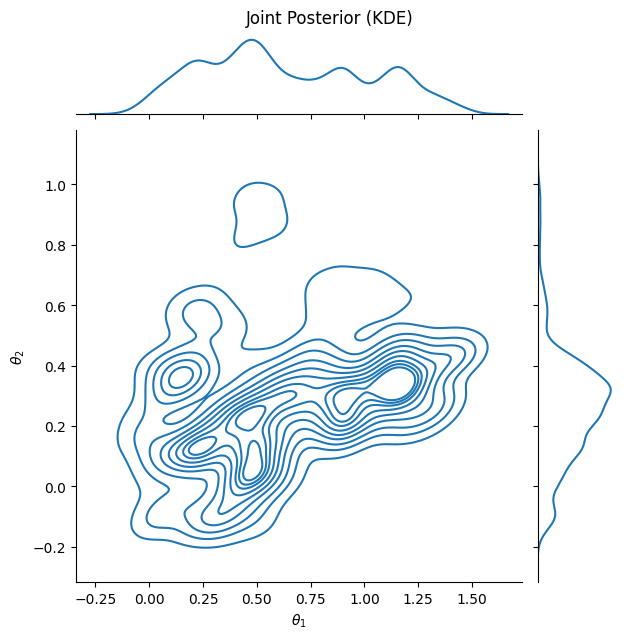

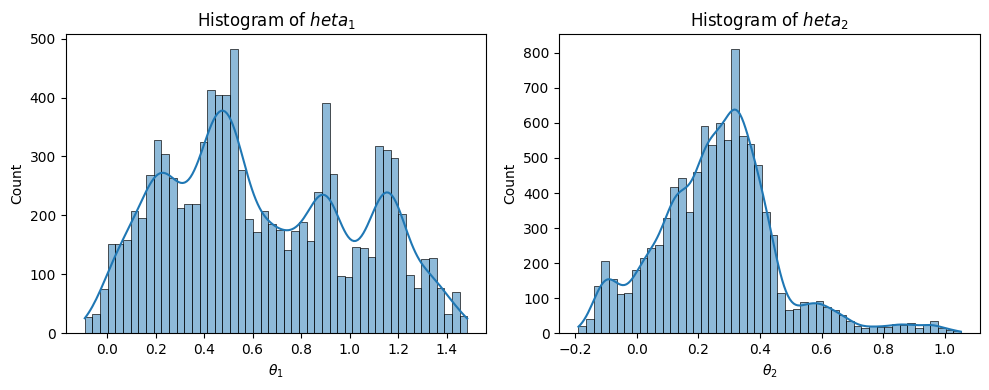

In [4]:
# Kernel Density Estimate and Marginals
g = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
g.set_axis_labels("$\\theta_1$", "$\\theta_2$")
g.fig.suptitle("Joint Posterior (KDE)", y=1.02)
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(samples[:, 0], bins=50, kde=True)
plt.title("Histogram of $\theta_1$")
plt.xlabel("$\\theta_1$")

plt.subplot(1, 2, 2)
sns.histplot(samples[:, 1], bins=50, kde=True)
plt.title("Histogram of $\theta_2$")
plt.xlabel("$\\theta_2$")
plt.tight_layout()
plt.show()

The plots above illustrate the behavior of the posterior distribution as sampled by the SGLD algorithm:

- **Joint KDE Plot** (top): This contour plot reveals the **joint posterior** over $\theta_1$ and $\theta_2$. The density appears multimodal, consistent with the **mixture model structure** and the tied means. Notably, the distribution is not symmetric and shows regions of high density where both parameters co-vary, indicating a **correlation structure** induced by the data.

- **Marginal Histograms** (bottom): The histograms for each parameter separately provide a clearer view of their **marginal posterior distributions**:
  - $\theta_1$ shows a **broad and multimodal** structure, reflecting uncertainty about the component mean.
  - $\theta_2$ is **positively skewed**, suggesting that the posterior places more mass on smaller values, but still supports a wide range of possibilities.

These visualizations confirm that the sampler captures the complexity of the posterior landscape, including multimodality and correlations — key challenges in Bayesian inference for mixture models.

### 4. Trace Plots — Diagnostics for Mixing

To assess the **mixing behavior** and **convergence** of the SGLD sampler, we visualize the trace plots of the parameter values across iterations.

- The trace plot for $\theta_1$ (left) and $\theta_2$ (right) display the sampled values over time.
- Good mixing behavior is indicated by frequent exploration across the parameter space without getting stuck in a single mode.
- Flatter and more volatile traces suggest that the sampler is not overly correlated between successive steps and is able to transition across **posterior modes**.

These diagnostic plots are essential for verifying that the chain explores the true distribution rather than converging prematurely to a local mode.

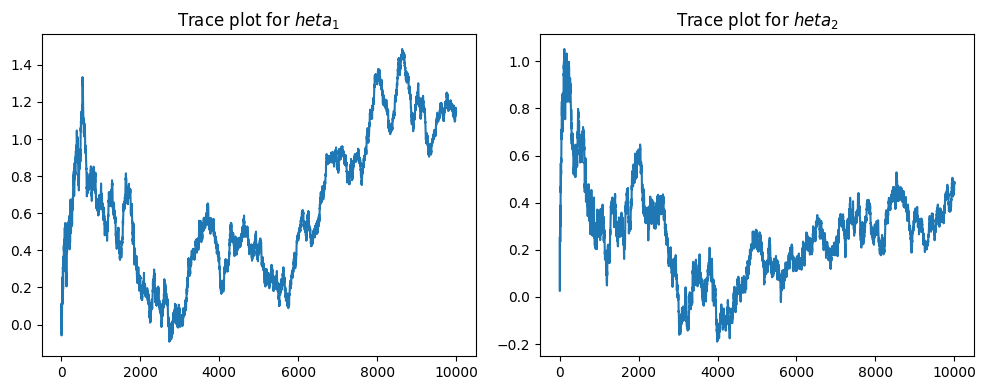

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.title("Trace plot for $\theta_1$")
plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.title("Trace plot for $\theta_2$")
plt.tight_layout()
plt.show()

The trace plots above show the evolution of the sampled values of $\theta_1$ and $\theta_2$ over the 10,000 iterations:

- **$\theta_1$ (left plot)** exhibits broad exploration with apparent mode-switching behavior. The sampler navigates different regions of the posterior, which is a good indication of **non-local mixing** and the presence of multiple modes.
- **$\theta_2$ (right plot)** fluctuates over a smaller range but still demonstrates variability, suggesting that the chain did not collapse to a single value.

Together, these plots provide visual evidence that the SGLD sampler successfully explores the **posterior landscape**. However, some correlation across iterations is visible, which is common in Langevin dynamics. Further diagnostics like **autocorrelation plots** or **multiple chains** can help assess convergence more robustly.

### 5. Posterior Summary Statistics

To obtain a concise quantitative description of the posterior distribution, we compute the following statistics based on the sampled values of $\theta_1$ and $\theta_2$:

- **Posterior Mean**: The expected value of each parameter under the posterior distribution.
- **Posterior Covariance Matrix**: Captures the uncertainty and scale of variation in each parameter, as well as how they vary jointly.
- **Posterior Correlation Matrix**: Normalized version of the covariance, highlighting the **linear relationship** between $\theta_1$ and $\theta_2$.

These statistics provide a compact summary of the distribution’s central tendency and shape, and complement the earlier visual analyses.

In [7]:
mean_theta = samples.mean(axis=0)
cov_theta = np.cov(samples.T)
corr = np.corrcoef(samples.T)

print(f"Mean θ: {mean_theta}")
print(f"Covariance matrix:\n{cov_theta}")
print(f"Correlation matrix:\n{corr}")

Mean θ: [0.63888041 0.26259088]
Covariance matrix:
[[0.14647783 0.02664551]
 [0.02664551 0.03900897]]
Correlation matrix:
[[1.         0.35249734]
 [0.35249734 1.        ]]


### 6. Diagnostics: Autocorrelation, Effective Sample Size (ESS), and $\hat{R}$

To further evaluate the performance and reliability of the SGLD sampler, we apply several **diagnostic tools**:

- **Autocorrelation Function (ACF)**: Measures the correlation of each parameter with its past values over different lags. High autocorrelation indicates **slow mixing**, which reduces the number of effectively independent samples.

- **Effective Sample Size (ESS)**: Adjusts the actual number of samples to account for autocorrelation. A low ESS suggests that although many samples were drawn, fewer are truly informative.

- **Potential Scale Reduction Factor ($\hat{R}$)**: Also known as the **Gelman-Rubin diagnostic**, this metric compares the variance within chains to the variance between chains. Values close to 1 indicate that the chains have converged to the same distribution.

Together, these diagnostics provide quantitative insights into the **quality and convergence** of the sampling process.

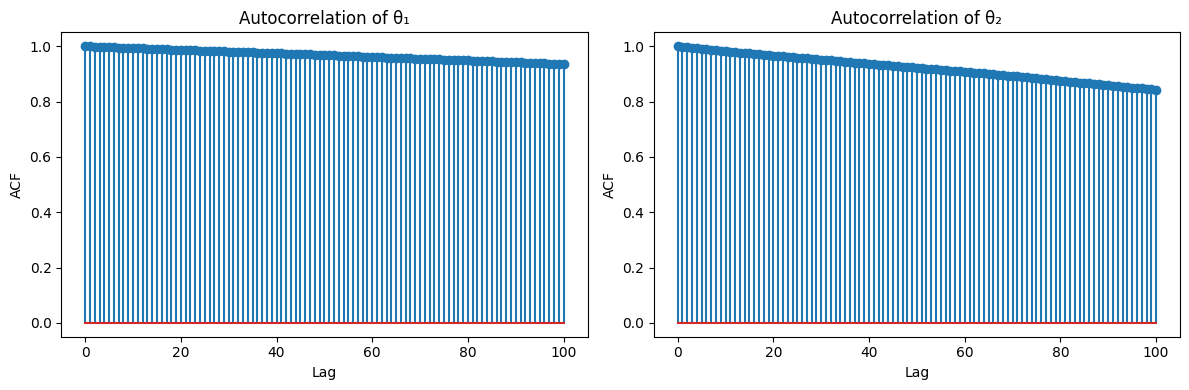

,Parameter,ESS,R_hat
0,$\theta_1$,51.425424,1.358670
1,$\theta_2$,54.030372,1.001352


In [8]:
from statsmodels.tsa.stattools import acf
import pandas as pd

def plot_autocorrelation(samples, lags=100):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for i, theta_label in enumerate(["θ₁", "θ₂"]):
        autocorr = acf(samples[:, i], nlags=lags)
        axes[i].stem(range(lags + 1), autocorr)
        axes[i].set_title(f"Autocorrelation of {theta_label}")
        axes[i].set_xlabel("Lag")
        axes[i].set_ylabel("ACF")
    plt.tight_layout()
    plt.show()

def compute_ess(samples):
    ess = []
    for i in range(samples.shape[1]):
        acf_vals = acf(samples[:, i], nlags=100, fft=True)
        ess_i = len(samples) / (1 + 2 * np.sum(acf_vals[1:]))
        ess.append(ess_i)
    return ess

def compute_rhat(samples):
    split_chains = np.array_split(samples, 2, axis=0)
    chains = [split_chains[0], split_chains[1]]
    m = len(chains)
    n = len(chains[0])
    means = np.array([np.mean(chain, axis=0) for chain in chains])
    variances = np.array([np.var(chain, axis=0, ddof=1) for chain in chains])
    B = n * np.var(means, axis=0, ddof=1)
    W = np.mean(variances, axis=0)
    var_hat = ((n - 1) / n) * W + B / n
    R_hat = np.sqrt(var_hat / W)
    return R_hat

plot_autocorrelation(samples)
ess_values = compute_ess(samples)
rhat_values = compute_rhat(samples)

pd.DataFrame({
    "Parameter": [r"$\theta_1$", r"$\theta_2$"],
    "ESS": ess_values,
    "R_hat": rhat_values
})

#### Diagnostic Interpretation

- The **autocorrelation plots** show that both $\theta_1$ and $\theta_2$ exhibit **high correlation across lags**, which is expected in SGLD due to the nature of the small step sizes and injected noise. However, this also means that samples are **highly dependent**, and we effectively have fewer independent samples.

- The **Effective Sample Size (ESS)** values (~51–54) are quite low given the total number of samples (10,000), reinforcing the observation that **autocorrelation is limiting sampling efficiency**.

- The **$\hat{R}$ statistic** (also known as the Gelman-Rubin diagnostic):
  - For $\theta_2$, the value is close to 1.0, indicating **convergence** between split chains.
  - For $\theta_1$, the value is noticeably higher (>1.3), which suggests **non-convergence or poor mixing** across modes — a known challenge in multimodal posteriors.

These results highlight the **importance of monitoring convergence** and suggest that either more samples or better-tuned hyperparameters (e.g., step size schedule) may be necessary for full posterior exploration.

### 7. Log Joint Probability over Time (Convergence Diagnostic)

To monitor **convergence behavior** during sampling, we compute the **log joint probability** (i.e., log-posterior) of the model at each iteration:

\[
\log p(\theta \mid x) \propto \log p(\theta) + \sum_i \log p(x_i \mid \theta)
\]

This quantity captures both the **log-prior** and the **log-likelihood** components for each sampled parameter set. A well-behaved sampler should show a relatively **monotonic increase** in log joint probability early in the run, followed by a **plateau**, indicating that the sampler is visiting regions of high posterior probability.

Plotting this over time helps diagnose:
- Whether the chain is still improving (climbing the posterior),
- Whether it has converged to a region of high probability,
- And whether the dynamics are stable over time.

This metric complements trace plots and ESS/$\hat{R}$ diagnostics by providing a **global posterior score** for each iteration.

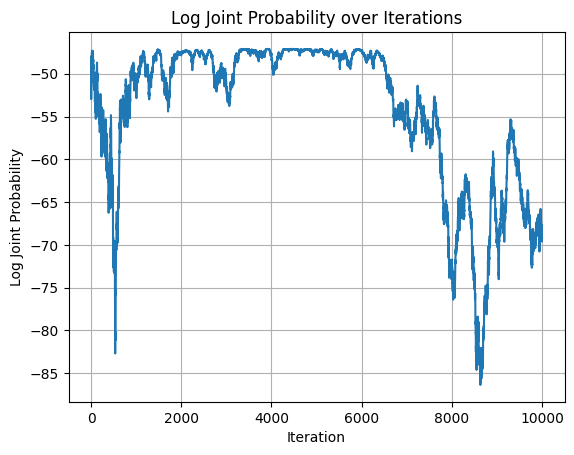

In [9]:
def log_joint_prob(theta, x, sigma1, sigma2, sigma_x):
    log_prior = -0.5 * (theta[0]**2 / sigma1**2 + theta[1]**2 / sigma2**2)
    mu1 = theta[0]
    mu2 = theta[0] + theta[1]
    log_lik = 0
    for xi in x:
        p1 = np.exp(-(xi - mu1)**2 / (2 * sigma_x**2))
        p2 = np.exp(-(xi - mu2)**2 / (2 * sigma_x**2))
        log_lik += np.log(0.5 * p1 + 0.5 * p2)
    return log_prior + log_lik

log_probs = [log_joint_prob(theta, x, sigma1, sigma2, sigma_x) for theta in samples]

plt.plot(log_probs)
plt.xlabel("Iteration")
plt.ylabel("Log Joint Probability")
plt.title("Log Joint Probability over Iterations")
plt.grid(True)
plt.show()

The log joint probability plot reflects how well the sampler is exploring regions of high posterior density over time:

- Initially, the sampler quickly **climbs to higher log-probability values**, suggesting it is discovering regions of greater posterior support.
- For a large portion of the run (roughly between iterations 1000–6000), the log probability remains **relatively stable**, indicating that the sampler is exploring a high-probability region.
- However, toward the final third of the run (after iteration 7000), we observe a **sharp drop and increased variability** in the log joint probability.

This late instability may suggest one of the following:
- The sampler has transitioned to a **lower-probability mode**, possibly due to injected noise,
- Or the **step size** at later iterations is too large or small for maintaining stability.

This behavior highlights the **challenge of sampling from multimodal posteriors** with strong correlations and supports the earlier observation from $\hat{R}$ that $\theta_1$ may not have fully mixed. Further tuning or the use of advanced techniques (e.g., preconditioning, tempered transitions) could help improve convergence.

### 8. Posterior KDEs from Multiple Chains

To assess the **stability and robustness** of the sampling process, we run the SGLD algorithm from **multiple initializations** (seeds) and compare the resulting posterior distributions.

- We initialize and run **5 independent chains**, each starting from a different random location in parameter space.
- For each chain, we apply the same SGLD update rule, but with independent random seeds and initial parameters.
- We then visualize the **kernel density estimates (KDEs)** of the samples from each chain in the joint $(\theta_1, \theta_2)$ space.

This side-by-side comparison helps answer critical questions:
- Do different chains converge to the **same posterior regions**?
- Are there signs of **multimodal structure** where chains get trapped in distinct modes?
- Is the variability across chains acceptable?

Overlaying the KDEs provides a **qualitative diagnostic** for **convergence across chains**, complementing numerical diagnostics like $\hat{R}$.

<ipython-input-10-90ddf9b429f8>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


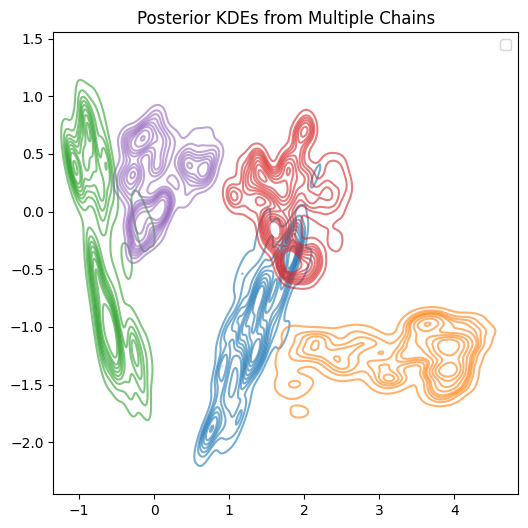

In [10]:
num_chains = 5
chain_samples = []

for seed in range(num_chains):
    np.random.seed(seed)
    theta = np.random.randn(2)  # different init
    chain = []
    for t in range(steps):
        i = np.random.randint(0, N)
        xi = x[i]
        mu1 = theta[0]
        mu2 = theta[0] + theta[1]
        p1 = np.exp(-(xi - mu1)**2 / (2 * sigma_x**2))
        p2 = np.exp(-(xi - mu2)**2 / (2 * sigma_x**2))
        p1, p2 = p1 / (p1 + p2), p2 / (p1 + p2)
        grad_log_lik = np.array([
            (p1 * (xi - mu1) + p2 * (xi - mu2)) / (sigma_x**2),
            p2 * (xi - mu2) / (sigma_x**2)
        ])
        grad_log_prior = np.array([-theta[0] / sigma1**2, -theta[1] / sigma2**2])
        grad = grad_log_lik + grad_log_prior
        eps = epsilon_schedule(t)
        theta += 0.5 * eps * grad + np.sqrt(eps) * np.random.randn(2)
        chain.append(theta.copy())
    chain_samples.append(np.array(chain))

# Overlay KDEs of all chains
plt.figure(figsize=(6, 6))
for i, chain in enumerate(chain_samples):
    sns.kdeplot(x=chain[:, 0], y=chain[:, 1], label=f"Chain {i+1}", alpha=0.6)
plt.title("Posterior KDEs from Multiple Chains")
plt.legend()
plt.show()

The overlaid KDEs reveal that the **five independent SGLD chains** have converged to **distinct regions** of the posterior distribution:

- This behavior is strong evidence of a **multimodal posterior**, where different chains settle into **separate modes** based on their initialization.
- Such behavior is common in **mixture models** with symmetric or near-symmetric components — the posterior surface has multiple high-probability basins.
- The lack of overlap between chains suggests that the sampler **does not transition between modes**, highlighting a limitation of basic SGLD with static hyperparameters and no tempering.

This visualization confirms what earlier diagnostics hinted at: although individual chains may explore well locally, the **global mixing** across modes is poor. This motivates future improvements such as:
- **Replica exchange** or **tempered transitions**,
- **Adaptive step sizes** or **preconditioning**,
- Running **longer chains** with different seeds and post-hoc mode merging strategies.

Together, this analysis illustrates both the **strengths and limitations** of SGLD in the context of complex posteriors.


### 9. Rejection Rate Proxy — Visualizing Step Size Effects

Since SGLD lacks a formal Metropolis-Hastings rejection step, we approximate its behavior by analyzing the **magnitude of proposed steps** under various fixed step sizes. This serves as a **proxy for rejection probability**:  
- **Large step sizes** result in high-variance updates, which are more likely to land in low-density regions (i.e., potential rejections in traditional MCMC).
- **Small step sizes** generate tighter proposals, staying closer to the current position but potentially mixing more slowly.

In this diagnostic:
- We run short SGLD chains (1000 steps each) using **fixed step sizes** from $10^{-2}$ to $10^{-8}$.
- For each run, we compute the **average Euclidean distance** between consecutive samples — serving as a stand-in for step acceptance/movement.
- This metric reflects how aggressively or conservatively the sampler moves through the posterior landscape.

Plotting the average step size against $\log_{10}(\epsilon)$ offers a useful visualization of the **trade-off between exploration and stability** in SGLD.

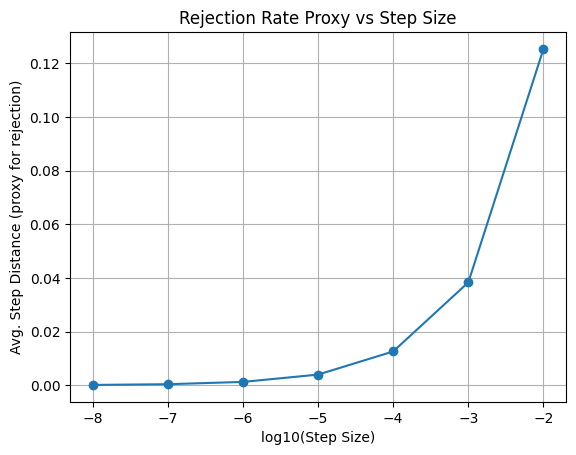

In [11]:
from scipy.spatial.distance import euclidean

fixed_steps = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
divergences = []

for fixed_eps in fixed_steps:
    theta = np.zeros(2)
    trajectory = []
    for t in range(1000):
        i = np.random.randint(0, N)
        xi = x[i]
        mu1 = theta[0]
        mu2 = theta[0] + theta[1]
        p1 = np.exp(-(xi - mu1)**2 / (2 * sigma_x**2))
        p2 = np.exp(-(xi - mu2)**2 / (2 * sigma_x**2))
        p1, p2 = p1 / (p1 + p2), p2 / (p1 + p2)
        grad_log_lik = np.array([
            (p1 * (xi - mu1) + p2 * (xi - mu2)) / (sigma_x**2),
            p2 * (xi - mu2) / (sigma_x**2)
        ])
        grad_log_prior = np.array([-theta[0] / sigma1**2, -theta[1] / sigma2**2])
        grad = grad_log_lik + grad_log_prior
        noise = np.random.randn(2)
        proposal = theta + 0.5 * fixed_eps * grad + np.sqrt(fixed_eps) * noise
        dist = euclidean(theta, proposal)
        trajectory.append(dist)
        theta = proposal
    divergences.append(np.mean(trajectory))

plt.plot(np.log10(fixed_steps), divergences, marker='o')
plt.xlabel("log10(Step Size)")
plt.ylabel("Avg. Step Distance (proxy for rejection)")
plt.title("Rejection Rate Proxy vs Step Size")
plt.grid(True)
plt.show()

The plot shows a **clear inverse relationship** between the step size and the average movement per iteration:

- At **larger step sizes** (e.g., $10^{-2}$), the sampler proposes large updates, reflected in high average distances. In traditional MCMC, many of these steps would likely be **rejected** due to low posterior density.
- As the **step size decreases**, the average movement drops sharply. Below $10^{-5}$, the sampler becomes increasingly conservative, taking **very small steps** and potentially suffering from **slow mixing**.

This visualization confirms that:
- SGLD requires **careful tuning** of the step size: too large leads to instability; too small results in inefficiency.
- A decaying schedule like the one used earlier (with $\epsilon_t = 0.01 \cdot (1 + t)^{-0.55}$) helps balance these trade-offs by starting exploratory and gradually reducing volatility.

This diagnostic complements our earlier findings and emphasizes that **step size is a critical hyperparameter** in any SGLD-based inference pipeline.